In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from plotnine import *

In [2]:
players_df = pd.read_csv('players.csv')
display(players_df.head())

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [3]:
combine_df_pre_2018 = pd.read_csv('combine_data_since_2000_PROCESSED_2018-04-26.csv')
combine_df_post_2018 = pd.read_csv('combine_data.csv')

In [4]:
combine_df_post_2018 = combine_df_post_2018.rename(columns={
    'player_name': 'name',
    'pos': 'position',
    'broad_jump': 'broad'
})
combine_df_pre_2018 = combine_df_pre_2018.rename(columns={
    'Player': 'name',
    'Pos': 'position',
    'BenchReps': 'bench',
    'BroadJump': 'broad',
    'Ht': 'ht',
    'Wt': 'wt',
    'Forty': 'forty',
    'Vertical': 'vertical',
})

cols = ['name', 'position', 'ht', 'wt', 'forty', 'bench', 'vertical', 'broad']
combine_df_post_2018_final = combine_df_post_2018[cols]
combine_df_pre_2018_final = combine_df_pre_2018[cols]

final_combine_df = pd.concat([combine_df_post_2018_final, combine_df_pre_2018_final], ignore_index=True)

In [5]:
phys_features = ['ht_in', 'wt', 'forty', 'bench', 'vertical', 'broad']
positions = ['QB', 'WR', 'RB', 'TE', 'OL', 'K']

def convert_ht(ht_str):
    if pd.isnull(ht_str):
        return np.nan
    if '-' not in str(ht_str):
        return str(ht_str)
    try:
        feet, inches = ht_str.split('-')
        return int(feet) * 12 + int(inches)
    except Exception:
        return np.nan

final_combine_df['ht_in'] = final_combine_df['ht'].apply(convert_ht)
final_combine_df['ht_in'] = final_combine_df['ht_in'].astype(float)
final_combine_df.drop('ht', axis=1, inplace=True)

for col in phys_features:
    final_combine_df[col] = final_combine_df.groupby('position')[col].transform(lambda x: x.fillna(x.mean()))
    
final_combine_df['vertical'] = final_combine_df['vertical'].fillna(0)
final_positions_df = final_combine_df[final_combine_df['position'].isin(positions)]


In [6]:
ct = make_column_transformer(
    (StandardScaler(), phys_features),
    remainder="drop"
)

model = KMeans(n_clusters=len(positions), random_state=1234)

pipeline = make_pipeline(ct, model)

X_train, X_test, y_train, y_test = train_test_split(
    final_positions_df[phys_features],
    final_positions_df['position'],
    test_size=0.2,
    random_state=10,
    stratify=final_positions_df['position']
)

pipeline.fit(X_train)

train_clusters = pipeline.named_steps['kmeans'].labels_

cluster_to_position = {}
for cluster in np.unique(train_clusters):
    indices = np.where(train_clusters == cluster)[0]
    most_common = y_train.iloc[indices].value_counts().idxmax()
    cluster_to_position[cluster] = most_common
display(cluster_to_position)

y_train_pred = [cluster_to_position[cluster] for cluster in train_clusters]

test_clusters = pipeline.predict(X_test)
y_test_pred = [cluster_to_position[cluster] for cluster in test_clusters]

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

# --- Print the metrics ---
print("Training Metrics:")
print(f"F1 Score: {train_f1:.3f}")
print("\nTest Metrics:")
print(f"F1 Score: {test_f1:.3f}")



{0: 'TE', 1: 'WR', 2: 'OL', 3: 'QB', 4: 'RB', 5: 'K'}

Training Metrics:
F1 Score: 0.804

Test Metrics:
F1 Score: 0.835


In [7]:
clusters = pipeline.predict(final_positions_df)
centroids = pipeline.named_steps['kmeans'].cluster_centers_

X_phys = final_positions_df[phys_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_phys)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a dataframe with PCA results and the cluster labels (from your pipeline)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# Transform centroids into the PCA space
centroids_pca = pca.transform(centroids)
centroids_df_pca = pd.DataFrame(centroids_pca, columns=['PC1', 'PC2'])
centroids_df_pca['cluster'] = range(len(centroids))

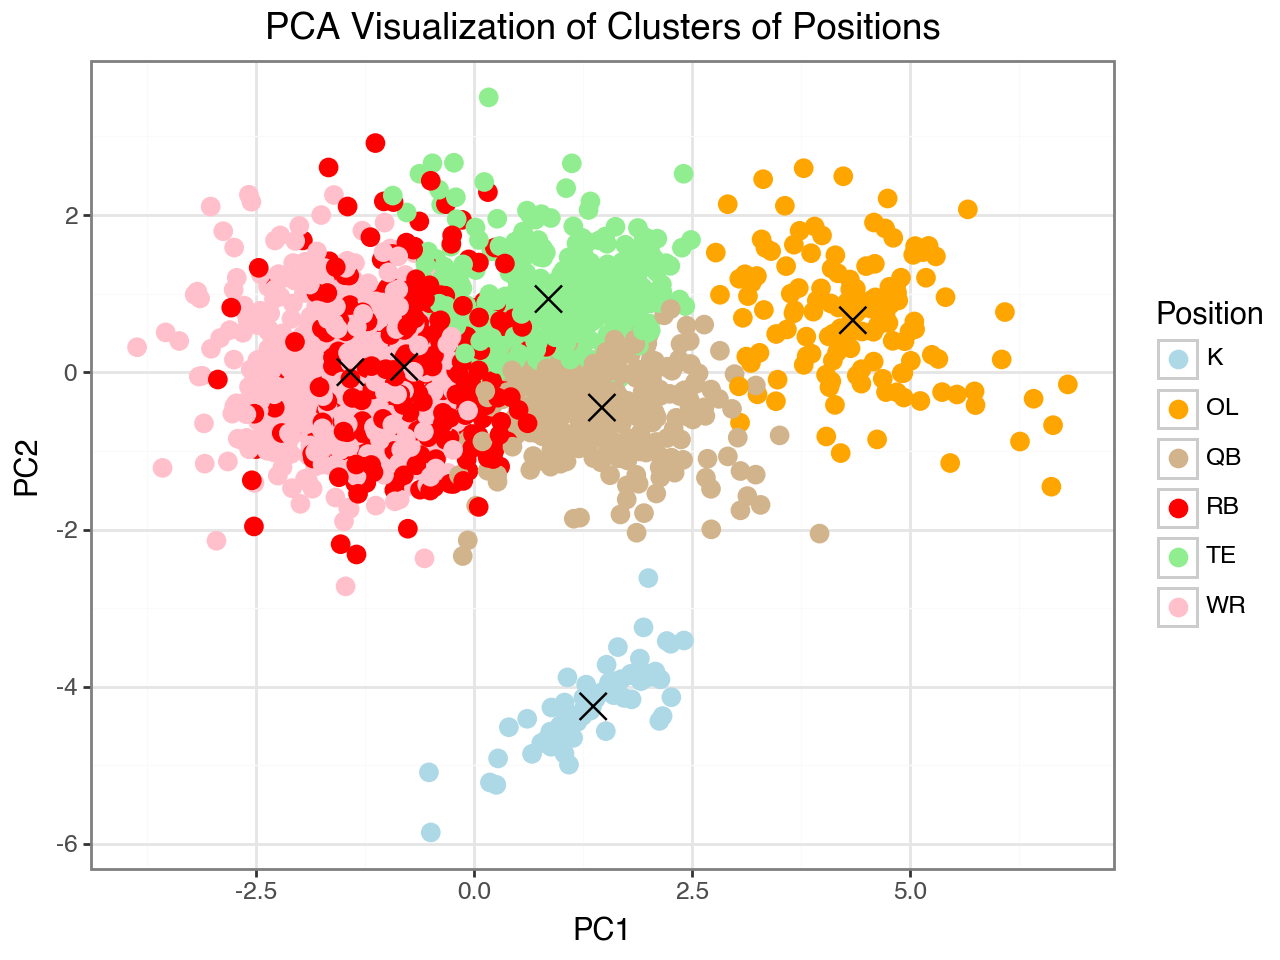

In [8]:
pca_df['position'] = pca_df['cluster'].map(cluster_to_position)
centroids_df_pca['position'] = centroids_df_pca['cluster'].map(cluster_to_position)

custom_colors = {
    'QB': 'tan',
    'RB': 'red',
    'WR': 'pink',
    'OL': 'orange',
    'K': 'lightblue',
    'TE': 'lightgreen',
}

pca_df['position'] = pca_df['cluster'].map(cluster_to_position)
centroids_df_pca['position'] = centroids_df_pca['cluster'].map(cluster_to_position)

(
    ggplot(pca_df, aes(x='PC1', y='PC2', color='position')) +
    geom_point(size=3) +
    geom_point(centroids_df_pca, aes(x='PC1', y='PC2'),
               color='black', size=5, shape='x') +
    labs(title='PCA Visualization of Clusters of Positions', color='Position') +
    scale_color_manual(values=custom_colors) + 
    theme_bw()
)
